<a href="https://colab.research.google.com/github/sachin5nowal/ECG-Heartbeat-classification/blob/main/ECG_Heartbeat_classification_Part_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@Introduction
"""
Title: Heart beat classification/Anomaly detection part-2 (Autoencoders)
Date: May 10,2020.
Version:1.0
Submitted by: Sachin Nowal
"""

'\nTitle: Heart beat classification/Anomaly detection part-2 (Autoencoders)\nDate: May 10,2020.\nVersion:1.0\nSubmitted by: Sachin Nowal\n'

In [ ]:
#Checking whether GPU is attached and running with the notebook
!nvidia-smi

Wed May 20 01:40:20 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    32W / 250W |    565MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

# Introduction
Here in this section we are going to use Autoencoder architecture (with LSTM/GRU) for encoding and decoding the sequential data.  The sequential data is beig fed into the LSTM layers and a dense representation of the ECG wave is being captured , this dense representation is used to construct the wave again and a reconstruction loss is being captured on the basis of which wave is being classified as normal/abnormal.

# Installing and loading libraries

In [ ]:
print("Installing libraries...")
!pip install -qq arff2pandas
!pip install -q -U watermark

Installing libraries...


In [ ]:
print("Loading libraries...")
from tensorflow.keras.layers import LSTM,GRU,Dropout,RepeatVector,TimeDistributed,Dense
from tensorflow.keras import Sequential
from tensorflow.keras.utils import plot_model
# from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import accuracy_score
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import tensorflow as tf
from arff2pandas import a2p
%matplotlib inline
RANDOM_SEED=42
np.random.seed(RANDOM_SEED)

Loading libraries...


# Loading Data

In [ ]:
#Loading data
data_folder_path="/content/drive/My Drive/drive_datasets/ecg_anomaly/ECG5000"
with open(data_folder_path+'/ECG5000_TRAIN.arff') as f:
  train = a2p.load(f)

with open(data_folder_path+'/ECG5000_TEST.arff') as f:
  test = a2p.load(f)

#Inspecting_data joining original test and train data
df = train.append(test)
df = df.sample(frac=1.0)
df.shape

(5000, 141)

In [ ]:
df.head()

,att1@NUMERIC,att2@NUMERIC,att3@NUMERIC,att4@NUMERIC,att5@NUMERIC,att6@NUMERIC,att7@NUMERIC,att8@NUMERIC,att9@NUMERIC,att10@NUMERIC,att11@NUMERIC,att12@NUMERIC,att13@NUMERIC,att14@NUMERIC,att15@NUMERIC,att16@NUMERIC,att17@NUMERIC,att18@NUMERIC,att19@NUMERIC,att20@NUMERIC,att21@NUMERIC,att22@NUMERIC,att23@NUMERIC,att24@NUMERIC,att25@NUMERIC,att26@NUMERIC,att27@NUMERIC,att28@NUMERIC,att29@NUMERIC,att30@NUMERIC,att31@NUMERIC,att32@NUMERIC,att33@NUMERIC,att34@NUMERIC,att35@NUMERIC,att36@NUMERIC,att37@NUMERIC,att38@NUMERIC,att39@NUMERIC,att40@NUMERIC,...,att102@NUMERIC,att103@NUMERIC,att104@NUMERIC,att105@NUMERIC,att106@NUMERIC,att107@NUMERIC,att108@NUMERIC,att109@NUMERIC,att110@NUMERIC,att111@NUMERIC,att112@NUMERIC,att113@NUMERIC,att114@NUMERIC,att115@NUMERIC,att116@NUMERIC,att117@NUMERIC,att118@NUMERIC,att119@NUMERIC,att120@NUMERIC,att121@NUMERIC,att122@NUMERIC,att123@NUMERIC,att124@NUMERIC,att125@NUMERIC,att126@NUMERIC,att127@NUMERIC,att128@NUMERIC,att129@NUMERIC,att130@NUMERIC,att131@NUMERIC,att132@NUMERIC,att133@NUMERIC,att134@NUMERIC,att135@NUMERIC,att136@NUMERIC,att137@NUMERIC,att138@NUMERIC,att139@NUMERIC,att140@NUMERIC,"target@{1,2,3,4,5}"
1001,1.469756,-1.048520,-3.394356,-4.254399,-4.162834,-3.822570,-3.003609,-1.799773,-1.500033,-1.025095,-0.166753,0.011275,-0.147008,-0.088714,-0.114587,-0.146307,-0.157915,-0.027796,-0.214186,-0.141600,-0.210829,-0.203778,-0.153019,-0.266533,-0.390077,-0.327032,-0.400833,-0.407830,-0.501358,-0.522868,-0.574155,-0.659348,-0.663703,-0.724858,-0.682038,-0.770026,-0.798246,-0.747866,-0.758533,-0.591910,...,1.487003,1.675518,1.836158,1.767251,1.735520,1.630994,1.380285,1.062822,0.829051,0.559157,0.189454,-0.083072,-0.387828,-0.484409,-0.490306,-0.518586,-0.419299,-0.440095,-0.357985,-0.486044,-0.486691,-0.376997,-0.444405,-0.295011,-0.381458,-0.357774,-0.308135,-0.068073,0.510416,0.873347,0.945178,1.275588,1.617218,1.580279,1.306195,1.351674,1.915517,1.672103,-1.039932,1
2086,-1.998602,-3.770552,-4.267091,-4.256133,-3.515288,-2.554540,-1.699639,-1.566366,-1.038815,-0.425483,-0.262474,-0.197361,-0.340497,-0.323774,-0.335513,-0.254583,-0.264334,-0.338740,-0.284649,-0.368613,-0.394213,-0.439726,-0.368993,-0.376742,-0.423022,-0.529464,-0.589248,-0.544008,-0.518129,-0.678544,-0.717577,-0.740041,-0.769233,-0.785213,-0.821685,-0.769256,-0.772686,-0.781586,-0.818404,-0.769080,...,1.780951,1.779466,1.754980,1.696125,1.596021,1.385371,1.189426,0.954776,0.739367,0.423573,0.085743,-0.030826,-0.042948,-0.122153,-0.101229,-0.135996,-0.093358,-0.113487,-0.118484,-0.088536,-0.020003,-0.029816,-0.044748,0.034468,0.070666,0.057764,0.120260,0.417549,0.799119,1.028602,1.008577,1.024698,1.051141,1.015352,0.988475,1.050191,1.089509,1.465382,0.799517,1
2153,-1.187772,-3.365038,-3.695653,-4.094781,-3.992549,-3.425381,-2.057643,-1.277729,-1.307397,-0.623098,-0.320708,-0.359462,-0.377039,-0.397033,-0.381755,-0.427911,-0.414237,-0.448439,-0.437101,-0.362470,-0.357754,-0.360832,-0.456013,-0.426373,-0.477425,-0.551853,-0.491515,-0.540644,-0.626111,-0.672909,-0.609645,-0.674574,-0.738285,-0.711991,-0.707088,-0.719290,-0.665765,-0.681393,-0.551106,-0.678160,...,1.539706,1.861135,1.823973,1.842621,1.807378,1.673375,1.435519,1.256942,1.141169,0.773353,0.352743,-0.006171,-0.082585,-0.174300,-0.050298,-0.190888,-0.151327,-0.106006,-0.101364,-0.116433,-0.127277,0.010743,-0.166507,-0.219952,-0.076155,-0.062330,0.009366,0.151061,0.459543,0.972686,1.085007,1.467196,1.413850,1.283822,0.923126,0.759235,0.932364,1.216265,-0.824489,1
555,0.604969,-1.671363,-3.236131,-3.966465,-4.067820,-3.551897,-2.582864,-1.804755,-1.688151,-1.025897,-0.434404,-0.391973,-0.488243,-0.431901,-0.389872,-0.552537,-0.522013,-0.412052,-0.435156,-0.485882,-0.495175,-0.472248,-0.491598,-0.542585,-0.495330,-0.514791,-0.556296,-0.654450,-0.652184,-0.705807,-0.764955,-0.806090,-0.826952,-0.834084,-0.824845,-0.894700,-0.855387,-0.843114,-0.803555,-0.649946,...,1.512614,1.786149,1.961367,1.853974,1.825461,1.679417,1.585913,1.286001,0.959101,0.604489,0.249181,-0.

In [ ]:
class_dict ={'Normal':1,'R on T':2,'PVC':3,'SP':4,'UB':5}
class_names = ['Normal','R on T','PVC','SP','UB']
new_columns = list(df.columns)
new_columns[-1] = 'target'
df.columns = new_columns

In [ ]:
df_normal=df[df['target']=='1'][:2400]
print(df_normal.target.value_counts())

1    2400
Name: target, dtype: int64


In [ ]:
df_test=df[df['target']!='1']
df_test=df_test.append(df[df['target']=='1'][2400:])

In [ ]:
print(df_test.target.value_counts())

2    1767
1     519
4     194
3      96
5      24
Name: target, dtype: int64


In [ ]:
def transpose_func(X,y):
  X=tf.transpose(X)
  y=tf.transpose(y)
  return X,y


def create_dataset(df):
  df.drop(['target'],axis=1,inplace=True)
  dataset=[[list(row[1])] for row in df.iterrows()]
  dataset = tf.data.Dataset.from_tensor_slices((dataset,dataset))
  dataset =dataset.map(transpose_func)
  dataset=dataset.batch(8, drop_remainder=True)
  return dataset

In [ ]:
train_dataset = create_dataset(df_normal.copy())
test_dataset = create_dataset(df_test.copy())

In [ ]:
df_test.shape

(2600, 141)

# Building model architechture (using LSTM) and training model

In [ ]:
model = Sequential()
model.add(LSTM(
    units=64,
    input_shape=(140,1)
))
model.add(Dropout(rate=0.2))
model.add(RepeatVector(n=140))
model.add(LSTM(units=64, return_sequences=True))
model.add(Dropout(rate=0.2))
model.add(TimeDistributed(
    Dense(units=1)
  )
)
model.compile(loss='mae', optimizer='adam')

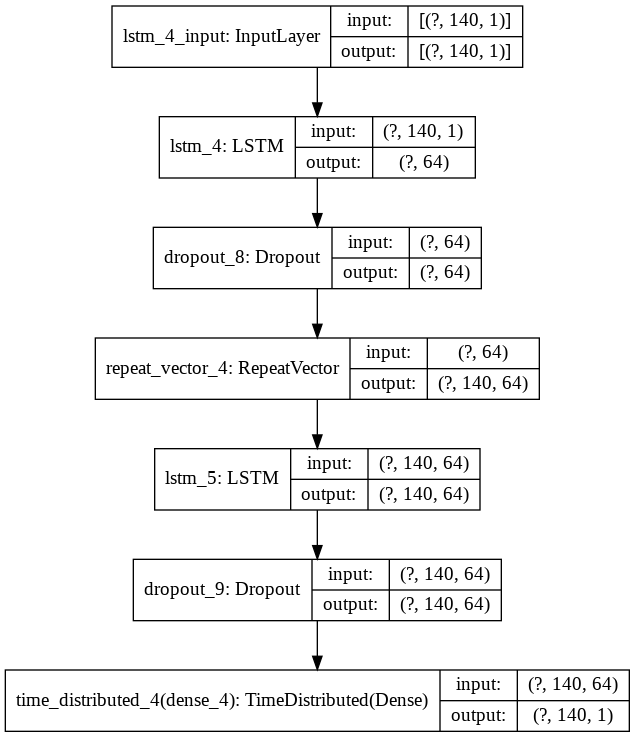

In [ ]:
plot_model(model, 'LSTM_autoencoder.png',show_shapes=True)

In [ ]:
History=model.fit(train_dataset, epochs=20)

Epoch 1/20
300/300 [==============================] - 3s 10ms/step - loss: 0.5267
Epoch 2/20
300/300 [==============================] - 3s 10ms/step - loss: 0.4745
Epoch 3/20
300/300 [==============================] - 3s 10ms/step - loss: 0.4002
Epoch 4/20
300/300 [==============================] - 3s 10ms/step - loss: 0.3686
Epoch 5/20
300/300 [==============================] - 3s 10ms/step - loss: 0.3167
Epoch 6/20
300/300 [==============================] - 3s 10ms/step - loss: 0.2674
Epoch 7/20
300/300 [==============================] - 3s 10ms/step - loss: 0.2381
Epoch 8/20
300/300 [==============================] - 3s 10ms/step - loss: 0.2294
Epoch 9/20
300/300 [==============================] - 3s 10ms/step - loss: 0.2099
Epoch 10/20
300/300 [==============================] - 3s 10ms/step - loss: 0.2030
Epoch 11/20
300/300 [==============================] - 3s 10ms/step - loss: 0.1995
Epoch 12/20
300/300 [==============================] - 3s 10ms/step - loss: 0.1922
Epoch 13/20
3

In [ ]:
history=History.history

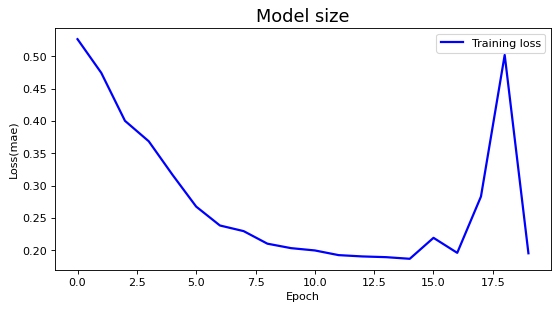

In [ ]:
#plt with training loss
fig, ax = plt.subplots(figsize=(8,4),dpi=80)
ax.plot(history['loss'],'b',label='Train',linewidth=2)
# ax.plot(history['val_loss'],'r',label='Validation',linewidth=2)
ax.set_title('Model size',fontsize=16)
ax.set_ylabel('Loss(mae)')
ax.set_xlabel('Epoch')
ax.legend(['Training loss'],loc='upper right')
plt.show()

In [ ]:
X_train_pred = model.predict(train_dataset)

def calculate_reconstruction_loss(dataset_org,dataset_pred):
  train_reconstruction_error=[]
  for train_org_ele,train_pred_ele in zip(dataset_org.as_numpy_iterator(),dataset_pred):
    a=np.asarray(train_org_ele[0].ravel())
    b=train_pred_ele.ravel()
    train_reconstruction_error.append(np.mean(np.abs(a-b)))

  return  train_reconstruction_error
reconstruction_error=calculate_reconstruction_loss(train_dataset.unbatch(),X_train_pred)

Text(0.5, 0, 'Data')

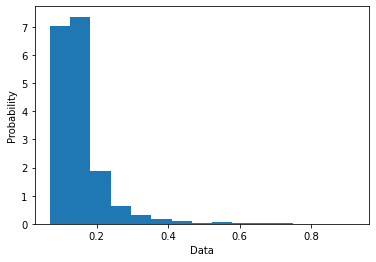

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
np.random.seed(42)

plt.hist(reconstruction_error, density=True, bins=15)  # `density=False` would make counts
plt.ylabel('Probability')
plt.xlabel('Data')

In [ ]:
# Setting reconstruction error at 0.3
max_reconstruction_error=0.3

In [ ]:
def threshold_level_cross(error,max_reconstruction_error=0.3):
  if(error<max_reconstruction_error):
    return 1
  else:
    return 0
# Model accuracy calculation on the trained dataset i.e. only normal ECG pulses
X_train_pred = model.predict(train_dataset)
reconstruction_error=calculate_reconstruction_loss(train_dataset.unbatch(),X_train_pred)
accuracy=sum([threshold_level_cross(e) for e in reconstruction_error])/len(reconstruction_error)
print("Training accuracy :",accuracy)

Training accuracy : 0.9604166666666667


# Evaluation on test dataset

In [ ]:
# test_pred

In [ ]:
df_test["target"]=df_test["target"].astype(int).apply(lambda x: 1 if x < 2 else 0)

In [ ]:
df_test["target"].value_counts()

0    2081
1     519
Name: target, dtype: int64

In [ ]:
test_pred = model.predict(test_dataset)
test_reconstruction_error=calculate_reconstruction_loss(test_dataset.unbatch(),test_pred)
print(len(test_reconstruction_error))
test_pred= [threshold_level_cross(e) for e in test_reconstruction_error]

# accuracy=sum([threshold_level_cross(e) for e in test_reconstruction_error])/len(test_reconstruction_error)
# print("Training accuracy :",accuracy)

2600


# Results

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(test_pred, df_test["target"]))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      2080
           1       0.96      0.96      0.96       520

    accuracy                           0.98      2600
   macro avg       0.98      0.98      0.98      2600
weighted avg       0.98      0.98      0.98      2600



# Auto encoder with GRU replacement

In [ ]:
train_dataset = create_dataset(df_normal.copy())
test_dataset = create_dataset(df_test.copy())

In [ ]:
model_gru = Sequential()
model_gru.add(GRU(
    units=64,
    input_shape=(140,1)
))
model_gru.add(Dropout(rate=0.2))
model_gru.add(RepeatVector(n=140))
model_gru.add(GRU(units=64, return_sequences=True))
model_gru.add(Dropout(rate=0.2))
model_gru.add(TimeDistributed(
    Dense(units=1)
  )
)
model_gru.compile(loss='mae', optimizer='adam')

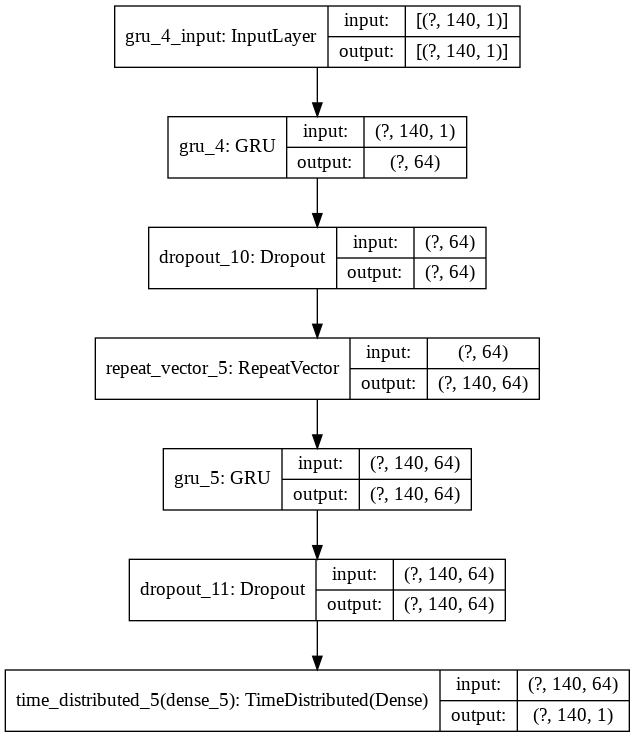

In [ ]:
plot_model(model_gru, 'GRU_autoencoder.png',show_shapes=True)

In [ ]:
History=model_gru.fit(train_dataset, epochs=20)

Epoch 1/20
300/300 [==============================] - 3s 10ms/step - loss: 0.5784
Epoch 2/20
300/300 [==============================] - 3s 10ms/step - loss: 0.4059
Epoch 3/20
300/300 [==============================] - 3s 10ms/step - loss: 0.3744
Epoch 4/20
300/300 [==============================] - 3s 9ms/step - loss: 0.3604
Epoch 5/20
300/300 [==============================] - 3s 10ms/step - loss: 0.3385
Epoch 6/20
300/300 [==============================] - 3s 9ms/step - loss: 0.3154
Epoch 7/20
300/300 [==============================] - 3s 9ms/step - loss: 0.3020
Epoch 8/20
300/300 [==============================] - 3s 9ms/step - loss: 0.2828
Epoch 9/20
300/300 [==============================] - 3s 10ms/step - loss: 0.2699
Epoch 10/20
300/300 [==============================] - 3s 10ms/step - loss: 0.2625
Epoch 11/20
300/300 [==============================] - 3s 10ms/step - loss: 0.2554
Epoch 12/20
300/300 [==============================] - 3s 10ms/step - loss: 0.2510
Epoch 13/20
300/3

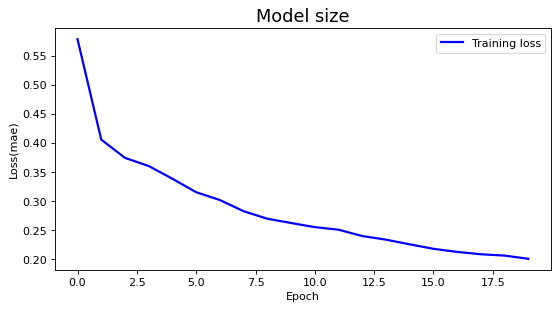

In [ ]:
history=History.history
#plt with training loss
fig, ax = plt.subplots(figsize=(8,4),dpi=80)
ax.plot(history['loss'],'b',label='Train',linewidth=2)
# ax.plot(history['val_loss'],'r',label='Validation',linewidth=2)
ax.set_title('Model size',fontsize=16)
ax.set_ylabel('Loss(mae)')
ax.set_xlabel('Epoch')
ax.legend(['Training loss'],loc='upper right')
plt.show()

In [ ]:
X_train_pred = model_gru.predict(train_dataset)

def calculate_reconstruction_loss(dataset_org,dataset_pred):
  train_reconstruction_error=[]
  for train_org_ele,train_pred_ele in zip(dataset_org.as_numpy_iterator(),dataset_pred):
    a=np.asarray(train_org_ele[0].ravel())
    b=train_pred_ele.ravel()
    train_reconstruction_error.append(np.mean(np.abs(a-b)))

  return  train_reconstruction_error
reconstruction_error=calculate_reconstruction_loss(train_dataset.unbatch(),X_train_pred)

Text(0.5, 0, 'Data')

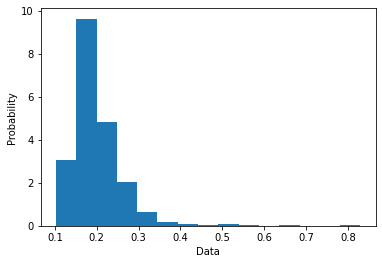

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
np.random.seed(42)

plt.hist(reconstruction_error, density=True, bins=15)  # `density=False` would make counts
plt.ylabel('Probability')
plt.xlabel('Data')

In [ ]:
# Setting reconstruction error at 0.35
max_reconstruction_error=0.35

In [ ]:
def threshold_level_cross(error,max_reconstruction_error=0.3):
  if(error<max_reconstruction_error):
    return 1
  else:
    return 0
# Model accuracy calculation on the trained dataset i.e. only normal ECG pulses
X_train_pred = model_gru.predict(train_dataset)
reconstruction_error=calculate_reconstruction_loss(train_dataset.unbatch(),X_train_pred)
accuracy=sum([threshold_level_cross(e,max_reconstruction_error) for e in reconstruction_error])/len(reconstruction_error)
print("Training accuracy :",accuracy)

Training accuracy : 0.9766666666666667


In [ ]:
df_test["target"]=df_test["target"].astype(int).apply(lambda x: 1 if x < 2 else 0)

In [ ]:
df_test["target"].value_counts()


1    2600
Name: target, dtype: int64

In [ ]:
test_pred = model_gru.predict(test_dataset)
test_reconstruction_error=calculate_reconstruction_loss(test_dataset.unbatch(),test_pred)
print(len(test_reconstruction_error))
test_pred= [threshold_level_cross(e) for e in test_reconstruction_error]

# accuracy=sum([threshold_level_cross(e) for e in test_reconstruction_error])/len(test_reconstruction_error)
# print("Training accuracy :",accuracy)

2600


In [ ]:
print(classification_report(test_pred, df_test["target"]))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      2075
           1       0.20      1.00      0.34       525

    accuracy                           0.20      2600
   macro avg       0.10      0.50      0.17      2600
weighted avg       0.04      0.20      0.07      2600



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
pd.Series(test_pred).value_counts()

0    2075
1     525
dtype: int64